# Breast Cancer Wisconsin (Diagnostic)

In [ ]:
import pandas as pd
import numpy as np
from engine import Value
from nn import Neuron, Layer, MLP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
DATA_URL = "../micrograd-python/dataset/"
df = pd.read_csv(DATA_URL + "data.csv")


## Initial Data Exploration

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.describe(
)

## Data Visualization

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="diagnosis", data=df, palette=["skyblue", "salmon"])
plt.xticks([0,1], ["Benign (0)", "Malignant (1)"])
plt.title("Diagnosis Class Distribution")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="radius_mean", hue="diagnosis", fill=True, palette=["blue", "red"], alpha=0.4)
plt.title("Distribution of Radius Mean by Diagnosis")
plt.show()


In [ ]:
corr = df.corr(numeric_only=True)

sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


corr_with_diag = corr["diagnosis"].sort_values(ascending=False)
print(corr_with_diag)

In [ ]:
# Feature Correlation with Diagnosis
corr_with_diag = corr["diagnosis"].sort_values(ascending=False)[1:]  # skip self-correlation
plt.figure(figsize=(10,4))
sns.barplot(x=corr_with_diag.values, y=corr_with_diag.index, palette="coolwarm")
plt.title("Feature Correlation with Diagnosis")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()


## Data Preprocessing

In [ ]:
# 1. Encode labels: Malignant (M) = 1.0, Benign (B) = -1.0
df["diagnosis"] = df["diagnosis"].map({"M": 1.0, "B": -1.0})

# 2. Normalize the input features (z-score)
df["concave points_worst"] = (df["concave points_worst"] - df["concave points_worst"].mean()) / df["concave points_worst"].std()
df["perimeter_worst"] = (df["perimeter_worst"] - df["perimeter_worst"].mean()) / df["perimeter_worst"].std()

# 3. Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 4. Manual train/test split (e.g., 80% train, 20% test)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# 5. Extract inputs and labels
xs_train = train_df[["concave points_worst", "perimeter_worst"]].values.tolist()
ys_train = train_df["diagnosis"].values.tolist()

xs_test = test_df[["concave points_worst", "perimeter_worst"]].values.tolist()
ys_test = test_df["diagnosis"].values.tolist()


## Initializing the model

In [ ]:
# 2 inputs, 1 hidden layer with 4 neurons, 1 output
model = MLP(2, [4, 1])

## Training the model

In [ ]:
epochs = 1000
learning_rate = 0.05
loss_history = []
for epoch in range(epochs):
    total_loss = 0

    # Forward pass: compute predictions
    ypred = [model([Value(x1), Value(x2)]) for x1, x2 in xs_train]

    # Compute loss (mean squared error)
    losses = [(yout - Value(ygt))**2 for ygt, yout in zip(ys_train, ypred)]
    loss = sum(losses) / len(losses)

    # backward pass
    for p in model.parameters():
        p.grad = 0.0 # Reset gradients
    loss.backward()  # Backward Propagation

    # Dynamic learning rate
    learning_rate = max(0.01, 1.0 - 0.9 * epoch / 100)  # decays but never below 0.1

    # update (gradient descent)
    for p in model.parameters():
        p.data += - learning_rate * p.grad

    # Save loss for plotting
    loss_history.append(loss.data)

    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}, Loss: {loss.data:.4f}")

# Plot training loss
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

## Model Evaluation

In [32]:
def compute_accuracy(xs, ys, model):
    correct = 0
    for (x1, x2), y_true in zip(xs, ys):
        y_pred = model([Value(x1), Value(x2)])
        y_pred_value = y_pred.data if isinstance(y_pred, Value) else y_pred[0].data
        if (y_pred_value > 0) == (y_true > 0):
            correct += 1
    return correct / len(ys)

# After training:
train_acc = compute_accuracy(xs_train, ys_train, model)
test_acc = compute_accuracy(xs_test, ys_test, model)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Train Accuracy: 94.51%
Test Accuracy: 93.86%


Model Evaluation Results:
Train Accuracy : 0.9451
Test Accuracy  : 0.9386
Precision      : 0.9348
Recall         : 0.9149
F1 Score       : 0.9247
ROC AUC        : 0.9870


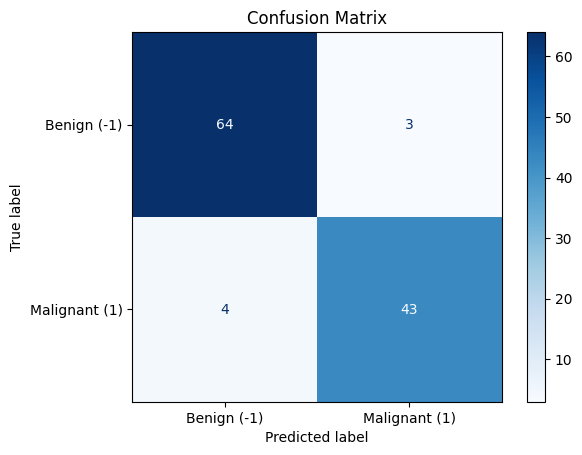

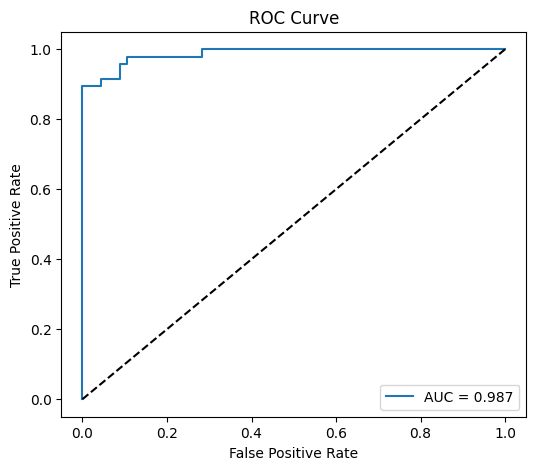

In [ ]:
# Predict using trained model 
def predict_values(model, xs):
    """Forward pass for all samples."""
    ypred = []
    for x1, x2 in xs:
        yout = model([Value(x1), Value(x2)]).data
        ypred.append(yout)
    return np.array(ypred)

# Get predictions
y_pred_train = predict_values(model, xs_train)
y_pred_test = predict_values(model, xs_test)

# Convert to binary labels (threshold = 0)
y_pred_train_bin = np.where(y_pred_train >= 0, 1.0, -1.0)
y_pred_test_bin = np.where(y_pred_test >= 0, 1.0, -1.0)

# --- Compute metrics ---
train_acc = accuracy_score(ys_train, y_pred_train_bin)
test_acc = accuracy_score(ys_test, y_pred_test_bin)
precision = precision_score(ys_test, y_pred_test_bin, pos_label=1.0)
recall = recall_score(ys_test, y_pred_test_bin, pos_label=1.0)
f1 = f1_score(ys_test, y_pred_test_bin, pos_label=1.0)
roc_auc = roc_auc_score(ys_test, y_pred_test)

# --- Print metrics ---
print("Model Evaluation Results:")
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"ROC AUC        : {roc_auc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(ys_test, y_pred_test_bin)
ConfusionMatrixDisplay(cm, display_labels=["Benign (-1)", "Malignant (1)"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(ys_test, y_pred_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [34]:
# Example patient data (un-normalized)
radius = 14.2
texture = 19.8

# Normalize with training stats (use same mean/std as preprocessing!)
radius_norm = (radius - df["radius_mean"].mean()) / df["radius_mean"].std()
texture_norm = (texture - df["texture_mean"].mean()) / df["texture_mean"].std()

# Wrap as Value and predict
pred = model([Value(radius_norm), Value(texture_norm)])

# Interpret result
print("Raw output:", pred.data)
if pred.data > 0:
    print("Predicted: Malignant (M)")
else:
    print("Predicted: Benign (B)")


Raw output: -0.30600790261173216
Predicted: Benign (B)


In [ ]:
from graphviz import Digraph

def trace(root):
    # builds a set of all. nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v): 
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot